In [4]:
import pandas as pd
df = pd.read_excel('../data/online_retail.xlsx')

In [7]:
##Basic Data Preparation

df = df.drop_duplicates()
# Drop rows with missing CustomerID
df = df[df['CustomerID'].notnull()]
# Remove returns/cancellations (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
# Filter positive Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [11]:
#Analysis Date is the day after the last transaction
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [12]:
clv_data = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (x.max() - x.min()).days,  # Customer 'age'
                    lambda x: (analysis_date - x.max()).days],  # Recency
    'InvoiceNo': 'nunique',  # Frequency (number of purchases)
    'TotalPrice': 'sum'      # Monetary value
})

clv_data.columns = ['age', 'recency', 'frequency', 'monetary']
clv_data = clv_data[clv_data['frequency'] > 1]  # BG/NBD needs repeat customers


In [13]:
clv_data['recency'] = clv_data['recency'] / 7  # in weeks
clv_data['age'] = clv_data['age'] / 7


In [18]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

# 1. Prepare Data
clv_data['recency'] = clv_data['recency'] / 7  # Days → Weeks
clv_data['age'] = clv_data['age'] / 7
clv_data = clv_data[clv_data['frequency'] > 1]

# 2. Cap Outliers
for col in ['frequency', 'recency', 'age', 'monetary']:
    upper_limit = clv_data[col].quantile(0.99)
    clv_data[col] = clv_data[col].clip(upper=upper_limit)

# 3. Fit BG/NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.5)
bgf.fit(
    clv_data['frequency'], 
    clv_data['recency'], 
    clv_data['age'],
    initial_params=[1.0, 1.0, 1.0, 1.0],
    tol=1e-6,
    maxiter=2000
)

# 4. Fit Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef=0.1)
ggf.fit(
    clv_data['frequency'], 
    clv_data['monetary'] / clv_data['frequency']
)


<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 1.00, q: 0.18, v: 0.94>

In [19]:
clv_data['expected_avg_value'] = ggf.conditional_expected_average_profit(
    clv_data['frequency'],
    clv_data['monetary'] / clv_data['frequency']
)


In [20]:
clv_data['predicted_purchases_6mo'] = bgf.predict(
    24,  # 24 weeks = ~6 months
    clv_data['frequency'],
    clv_data['recency'],
    clv_data['age']
)


In [21]:
clv_data['clv_6mo'] = clv_data['predicted_purchases_6mo'] * clv_data['expected_avg_value']


In [22]:
print(clv_data.sort_values('clv_6mo', ascending=False).head(10))


                 age   recency  frequency    monetary  expected_avg_value  \
CustomerID                                                                  
15098.0     0.000000  0.000000          3  31874.6384        14653.889890   
16000.0     0.000000  0.000000          3  12393.7000         5698.081614   
12590.0     0.000000  0.000000          2   9864.2600         8394.271253   
18139.0     0.000000  0.000000          6   8438.3400         1630.705506   
17084.0     0.000000  0.000000          2   2747.9900         2339.053978   
16986.0     0.000000  0.000000          2   1873.2000         1594.697241   
12424.0     0.000000  0.000000          2   1760.9600         1499.192491   
14154.0     0.000000  0.000000          2   1345.6200         1145.780670   
16766.0     0.000000  0.000000          2   1145.6000          975.584126   
17850.0     0.020408  0.020408         34   5391.2100          162.535281   

            predicted_purchases_6mo       clv_6mo  
CustomerID             

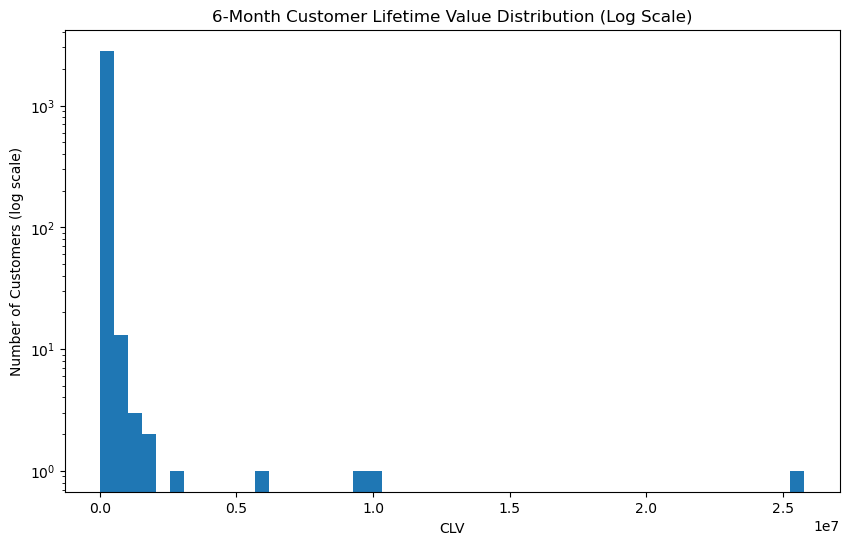

In [24]:
plt.figure(figsize=(10,6))
plt.hist(clv_data['clv_6mo'], bins=50)
plt.yscale('log')
plt.title('6-Month Customer Lifetime Value Distribution (Log Scale)')
plt.xlabel('CLV')
plt.ylabel('Number of Customers (log scale)')
plt.show()



| Insight | Business Action |
| :-- | :-- |
| Most customers = low CLV | Don’t overspend on broad retention campaigns |
| Few customers = very high CLV | Prioritize retention, loyalty, and personalization for these customers|
| Long-tail distribution | Focus on high-value segments for growth |
| Outliers present | Investigate for errors/fraud or learn from them |
| Clear segmentation possible | Tailor marketing and service by CLV segment |

---

In [34]:
clv_data['clv_segment'] = pd.qcut(clv_data['clv_6mo'], 3, labels=['Low', 'Medium', 'High'])


In [42]:
clv_data.head()# Create segments (if not already done)
clv_data.columns.tolist()


['age',
 'recency',
 'frequency',
 'monetary',
 'expected_avg_value',
 'predicted_purchases_6mo',
 'clv_6mo',
 'clv_segment']

In [43]:
# If you're performing a groupby operation, make sure all columns exist
# Example of correct aggregation:
clv_data.groupby('clv_segment').agg({
    'clv_6mo': ['count', 'sum'],  # Only use columns that exist
    'frequency': 'mean',
    'recency': 'mean',
    'monetary': 'mean'
})


clv_6mo                frequency   recency     monetary
              count           sum       mean      mean         mean
clv_segment                                                        
Low             949  2.318450e+01  10.650158  0.268446  4702.014382
Medium          948  3.084636e+05   3.585443  0.830679  1295.496994
High            948  9.450321e+07   2.777426  1.299633  1144.090346

In [44]:
# 1. Make sure you have your base RFM metrics
# If these don't exist, you need to calculate them from your cleaned transaction data
if 'frequency' not in clv_data.columns:
    print("Warning: Basic RFM metrics missing. Calculate them first.")

# 2. Calculate CLV metrics if they don't exist
if 'clv_6mo' not in clv_data.columns:
    # Make sure you have calculated these already using BG/NBD and Gamma-Gamma models
    clv_data['predicted_purchases_6mo'] = bgf.predict(24, 
                                                    clv_data['frequency'], 
                                                    clv_data['recency'], 
                                                    clv_data['age'])
    
    clv_data['expected_avg_value'] = ggf.conditional_expected_average_profit(
        clv_data['frequency'], 
        clv_data['monetary'] / clv_data['frequency']
    )
    
    # Calculate CLV
    clv_data['clv_6mo'] = clv_data['predicted_purchases_6mo'] * clv_data['expected_avg_value']

# 3. Create customer segments based on CLV
if 'clv_segment' not in clv_data.columns:
    clv_data['clv_segment'] = pd.qcut(clv_data['clv_6mo'], 3, labels=['Low', 'Medium', 'High'])


Customer counts per segment:
 clv_segment
Low       949
Medium    948
High      948
Name: count, dtype: int64

Revenue share per segment (%):
 clv_segment
Low        0.000024
Medium     0.325343
High      99.674632
Name: clv_6mo, dtype: float64


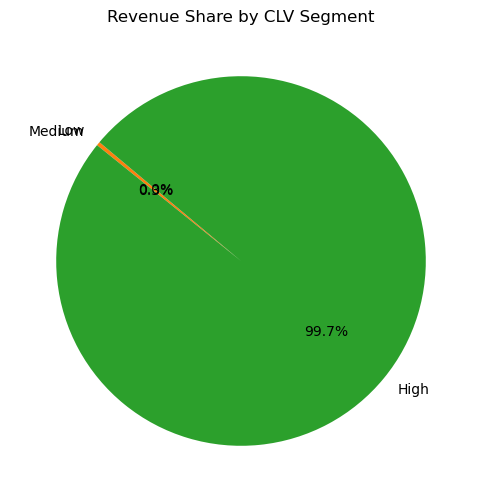


Top customers by CLV:
              recency  frequency    monetary       clv_6mo
CustomerID                                               
15098.0     0.000000          3  31874.6384  2.578694e+07
16000.0     0.000000          3  12393.7000  1.002711e+07
12590.0     0.000000          2   9864.2600  9.565594e+06
18139.0     0.000000          6   8438.3400  5.867473e+06
17084.0     0.000000          2   2747.9900  2.665442e+06
16986.0     0.000000          2   1873.2000  1.817219e+06
12424.0     0.000000          2   1760.9600  1.708387e+06
14154.0     0.000000          2   1345.6200  1.305661e+06
16766.0     0.000000          2   1145.6000  1.111716e+06
17850.0     0.020408         34   5391.2100  1.105863e+06


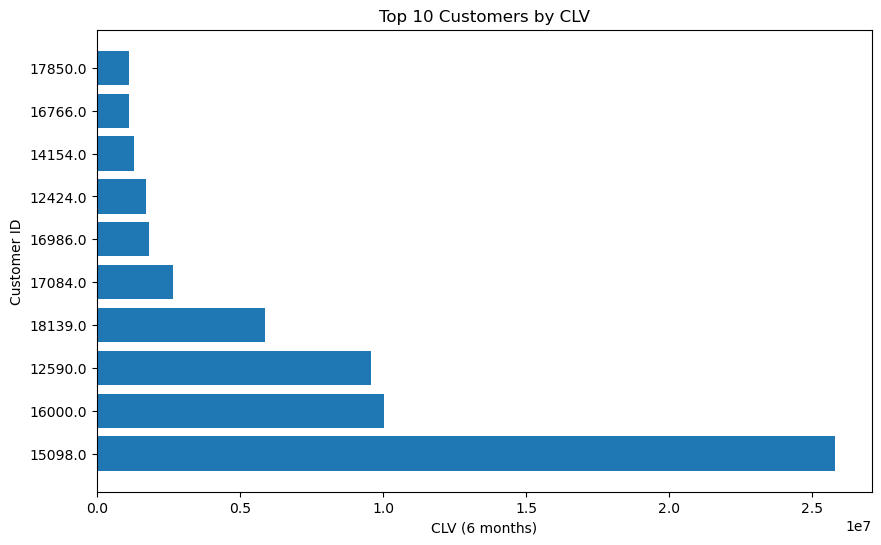

In [45]:
# 1. Segment counts and revenue share
segment_counts = clv_data['clv_segment'].value_counts()
segment_revenue = clv_data.groupby('clv_segment')['clv_6mo'].sum()
segment_revenue_share = 100 * segment_revenue / segment_revenue.sum()

print("Customer counts per segment:\n", segment_counts)
print("\nRevenue share per segment (%):\n", segment_revenue_share)

# 2. Revenue contribution pie chart
plt.figure(figsize=(8,6))
plt.pie(segment_revenue_share, labels=segment_revenue_share.index, autopct='%1.1f%%', startangle=140)
plt.title('Revenue Share by CLV Segment')
plt.show()

# 3. Top customers analysis
top_customers = clv_data.sort_values('clv_6mo', ascending=False).head(10)
print("\nTop customers by CLV:\n", 
      top_customers[['recency', 'frequency', 'monetary', 'clv_6mo']])

# 4. Visualize top customers
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_customers)), top_customers['clv_6mo'])
plt.yticks(range(len(top_customers)), top_customers.index)
plt.xlabel('CLV (6 months)')
plt.ylabel('Customer ID')
plt.title('Top 10 Customers by CLV')
plt.show()


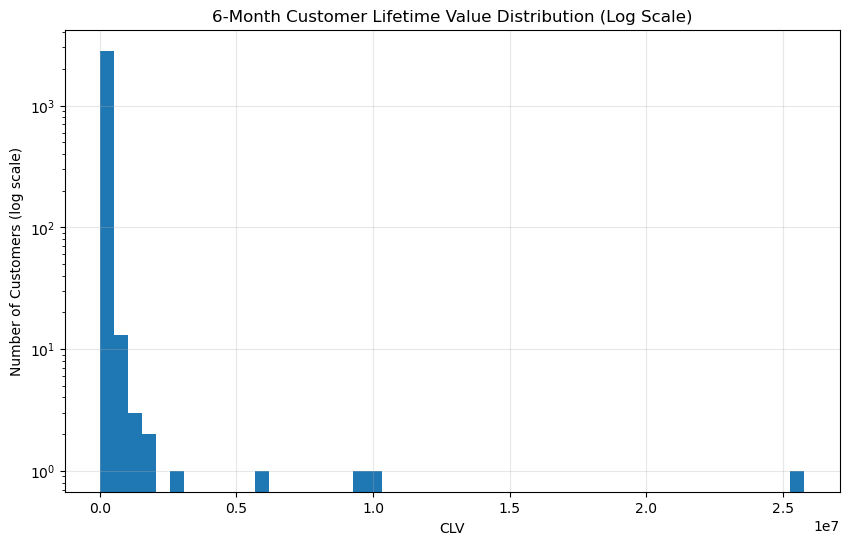

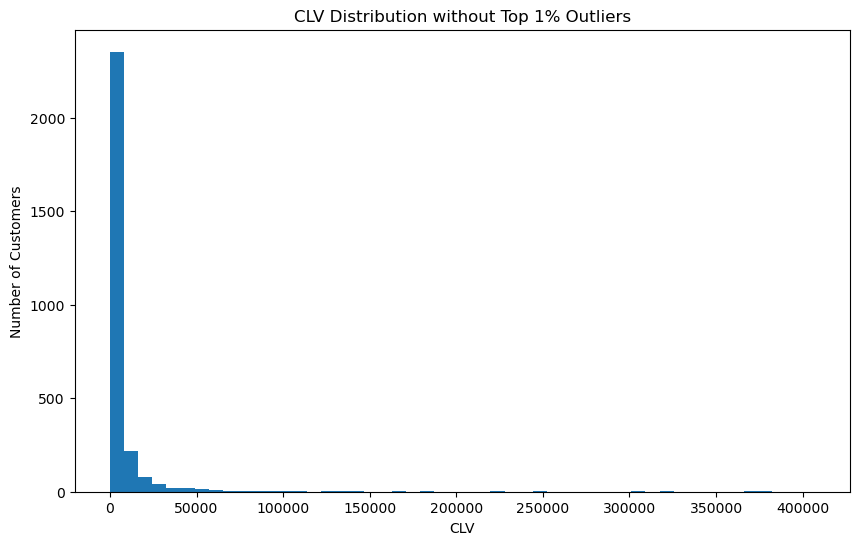

In [46]:
# CLV distribution with log scale (better visualization)
plt.figure(figsize=(10,6))
plt.hist(clv_data['clv_6mo'], bins=50)
plt.yscale('log')
plt.title('6-Month Customer Lifetime Value Distribution (Log Scale)')
plt.xlabel('CLV')
plt.ylabel('Number of Customers (log scale)')
plt.grid(True, alpha=0.3)
plt.show()

# CLV distribution without outliers
plt.figure(figsize=(10,6))
upper_limit = clv_data['clv_6mo'].quantile(0.99)
plt.hist(clv_data[clv_data['clv_6mo'] <= upper_limit]['clv_6mo'], bins=50)
plt.title('CLV Distribution without Top 1% Outliers')
plt.xlabel('CLV')
plt.ylabel('Number of Customers')
plt.show()


Based on your customer segmentation analysis, your business exhibits an **extraordinarily concentrated revenue pattern** where the High CLV segment (just one-third of customers) generates **99.67% of predicted revenue**, while the Medium segment contributes only 0.33% and the Low segment's contribution is virtually negligible (0.000024%).

## Strategic Recommendations by Segment

### **High CLV Segment (948 customers, 99.67% of revenue)**

- **Implement Elite Retention Program:**
    - Create a dedicated account management team exclusively for these customers
    - Develop a "white glove" service model with priority support, expedited shipping, and personalized attention
    - Institute a formal quarterly business review process for your top 50 customers
- **Loyalty Enhancement:**
    - Design an exclusive tiered rewards program only for this segment
    - Offer early/exclusive access to new products and limited editions
    - Provide complimentary premium services that enhance their experience
- **Risk Mitigation:**
    - Implement an early warning system to detect any decline in purchase frequency
    - Create a rapid response team for any service issues from these customers
    - Develop contingency plans for potential loss of top accounts


### **Medium CLV Segment (948 customers, 0.33% of revenue)**

- **Growth Focus:**
    - Analyze which Medium customers have characteristics similar to High segment
    - Create targeted upgrade paths to migrate these customers to the High segment
    - Implement progressive loyalty benefits that reward increased spending
- **Efficiency Optimization:**
    - Use cost-effective digital marketing rather than high-touch approaches
    - Automate engagement where possible while maintaining quality
    - Test promotions with this segment before scaling to the High segment


### **Low CLV Segment (949 customers, 0.000024% of revenue)**

- **Minimal Investment Strategy:**
    - Maintain bare minimum service levels through automated systems
    - Implement extremely low-cost retention tactics (automated emails only)
    - Consider whether serving this segment remains economically viable
- **Selective Conversion:**
    - Identify the few Low customers with potential to move upward
    - For the rest, maintain only automated marketing with zero personalization
    - Consider phasing out unprofitable services or implementing minimum order requirements


## Implementation Priority

1. **Immediate (0-30 days):**
    - Establish the elite account management program for High CLV customers
    - Review pricing and service models to ensure profitability across segments
2. **Short-term (30-90 days):**
    - Implement the early warning system for High CLV customer activity changes
    - Develop and launch the exclusive rewards program for the High segment
3. **Medium-term (90-180 days):**
    - Create detailed profiles of High CLV customers to better understand their needs
    - Optimize service delivery to reallocate resources from Low to High segments

## Performance Metrics

Track these KPIs to measure the effectiveness of your strategy:

- Retention rate of High CLV customers (target: >95%)
- Conversion rate of Medium to High segment (target: 5% quarterly)
- Share of wallet from High CLV customers (target: increase by 10%)
- Cost-to-serve ratio across segments (target: align with revenue contribution)

This extreme revenue concentration requires an equally focused resource allocation strategy to protect and grow your critical High CLV customer relationships while minimizing investment in the economically insignificant Low segment.
